## CSCI461 Project
## Energy Prediction Model

## Introduction
### Overview

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

In this project, we will build these models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

### The challenge
We must construct accurate projections of metered building energy use in the following areas: chilled water, electric, hot water, and steam meters in this competition. Over 1,000 structures were studied over a three-year period. The goal is that, with more accurate estimations of these energy-saving projects, big-scale investors and financial institutions will be more motivated to invest in this area, allowing advances in building efficiency to be made.

### Main Files
**1) train.csv**

Contains the training data including building_id, meter, timestamp and meter_reading (the target variable).

**2) building_meta.csv**

Contains information about the building such as site_id, building_id, primary_use, square_feet, year_built, and floor_count.

**3) weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site. It includes information about air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, and wind_speed.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

## Exploring "building_metadata.csv" file

In [ ]:
#Load data
file_name = 'building_metadata.csv'
building_metadata_df = pd.read_csv(file_name)
building_metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
building_metadata_df.shape

(1449, 6)

In [ ]:
# Check for missing or null values
building_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [ ]:
year_build_missing_per = 100*(building_metadata_df.year_built.isna().sum()/len(building_metadata_df))
floor_count_missing_per = 100*(building_metadata_df.floor_count.isna().sum()/len(building_metadata_df))

print("Percentage of missing values in year_build column is ", year_build_missing_per, "%")
print("Percentage of missing values in floor_count column is ", floor_count_missing_per, "%")

Percentage of missing values in year_build column is  53.41614906832298 %
Percentage of missing values in floor_count column is  75.50034506556246 %


**Because more than half of their values are missing, these two features are not going to be particularly useful. So, we will drop them.**

In [ ]:
building_metadata_df.drop(['floor_count', 'year_built'], axis=1, inplace=True)

In [ ]:
#Check for duplicate values
building_metadata_df.duplicated().sum()

0

In [ ]:
building_metadata_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [ ]:
building_metadata_df['building_id'].unique()

array([   0,    1,    2, ..., 1446, 1447, 1448], dtype=int64)

<AxesSubplot:xlabel='site_id', ylabel='count'>

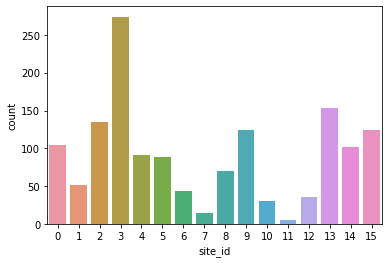

In [ ]:
#Plot to represent number of buildings in every site
sb.countplot(x='site_id', data=building_metadata_df)

In [ ]:
#Number of buildings in every primary_use
building_metadata_df['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In [ ]:
#Mean Of square_feet by primary_use
building_metadata_df.groupby('primary_use').square_feet.agg(['mean'])

,mean
primary_use,
Education,104329.000000
Entertainment/public assembly,80584.070652
Food sales and service,38485.000000
Healthcare,140480.869565
Lodging/residential,85368.605442
Manufacturing/industrial,41120.833333
Office,87065.627240
Other,31456.560000
Parking,279341.772727


## Exploring "train.csv" file

In [ ]:
file_name = 'train.csv'
train_df = pd.read_csv(file_name)
#the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
train_df['timestamp'] = pd.to_datetime(train_df['timestamp']) 
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
#summary of a train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          int64         
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [ ]:
#the sum of the null values 
train_df.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [ ]:
# dimensionality of the train data.
print(train_df.shape)

(20216100, 4)


In [ ]:
# statistical details about train data
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [ ]:
print(train_df["timestamp"].min() , train_df["timestamp"].max(),sep ="\n")

2016-01-01 00:00:00
2016-12-31 23:00:00


In [ ]:
# statistical details about meter_reading
train_df['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
zeros = train_df[train_df['meter_reading']== 0].shape[0] / train_df.shape[0]
print('Zero reading percentile : {}'.format(round(zeros,3)))

Zero reading percentile : 0.093


The reading value is zero in 9% of the time. We know that some buildings have many meter types, thus we may assume that using seasonal energy meters will result in zeros. We don't need to use cooled water on chilly days, to be more specific. Similarly, hot water use might vary from time to time. Those data, however, might be absent because no energy usage makes no sense!

In [ ]:
#converting the meters to what they stand for 
train_df['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)

Text(0.5, 1.0, 'Meters percentage having zero readings')

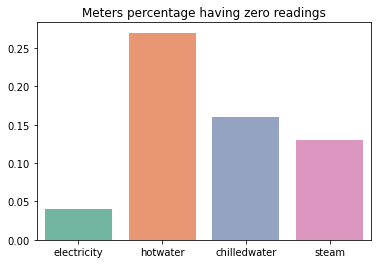

In [ ]:
# to show the precentage of meters that having zeroes 
meter_dict = {}
for i in train_df["meter"].unique():
    percent = round(train_df[train_df['meter_reading']== 0]["meter"].value_counts()[i] /train_df["meter"].value_counts()[i],2)
    meter_dict[i] = percent
zero_meter = pd.Series(meter_dict)
sb.barplot(x=zero_meter.index, y= zero_meter,palette ="Set2")
plt.title("Meters percentage having zero readings")

In [ ]:
train_df["month"] = train_df.timestamp.dt.month

Text(0.5, 1.0, 'For hot water')

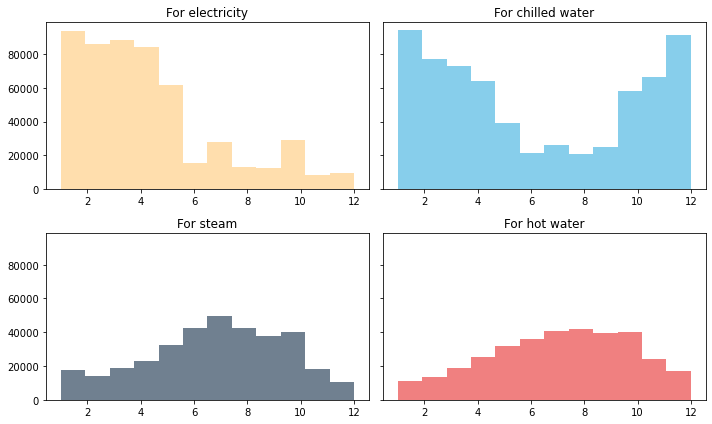

In [ ]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train_df[(train_df.meter_reading == 0) & (train_df.meter=="electricity")],bins =12,color = "navajowhite")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train_df[(train_df.meter_reading == 0) & (train_df.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train_df[(train_df.meter_reading == 0) & (train_df.meter=="steam")],bins =12,color = "slategrey")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train_df[(train_df.meter_reading == 0) & (train_df.meter=="hotwater")],bins =12,color = "lightcoral")
axs[1][1].set_title("For hot water")

As seen in the graphs, zero readings vary with time and meter type. The first five months of the year have witnessed electricity meter zeros. The number of zero readings decreases as the month progresses. Seasonal variations in chilled and hot water zeros can be found. The distribution of zeros in steam and hot water is remarkably similar.

In [ ]:
# Function for remove Outlier
def removeOutliers(data, outlierConstant = 1.5):
    values = np.array(data)
    upper_quartile = np.percentile(values, 75)
    lower_quartile = np.percentile(values, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartile = (lower_quartile - IQR, upper_quartile + IQR)
    results = []
    for i in values.tolist():
        if i >= quartile[0] and i <= quartile[1]:
            results.append(i)
    return results

In [ ]:
target_noOutlier = removeOutliers(train_df.meter_reading)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

Text(0.5, 1.0, 'Target with Log Transform')

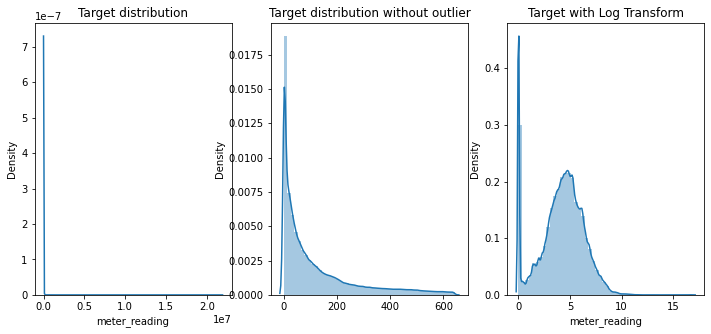

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(12,5))

sb.distplot(train_df.meter_reading,hist = False,ax = axes[0])
axes[0].set_title("Target distribution")

sb.distplot(target_noOutlier,ax=axes[1])
axes[1].set_title("Target distribution without outlier")

sb.distplot(np.log1p(train_df.meter_reading),ax = axes[2])
axes[2].set_title("Target with Log Transform")

In [ ]:
train_df['meter_reading_log'] = np.log1p(train_df['meter_reading'])

The meter reading variable is highly right-skewed, with a large number of zeros. A skewed distribution is transformed into a more normalized dataset via logarithmic transformation. We have outliers in addition to zeros readings!

<AxesSubplot:xlabel='meter', ylabel='count'>

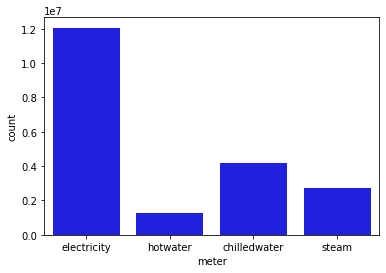

In [ ]:
sb.countplot(x= "meter",data = train_df,color = 'b')

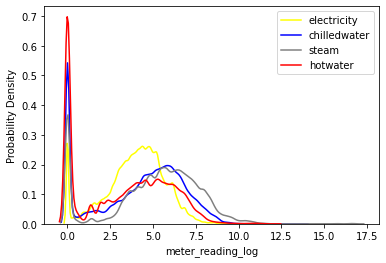

In [ ]:
#Graphs shows distribution meter_reading in each meter category

sb.kdeplot(train_df.loc[(train_df['meter']=='electricity'), 
            "meter_reading_log"], color='yellow', shade=False, label='electricity')

sb.kdeplot(train_df.loc[(train_df['meter']=='chilledwater'), 
            "meter_reading_log"], color='b', shade=False, label='chilledwater')

sb.kdeplot(train_df.loc[(train_df['meter']=='steam'), 
            "meter_reading_log"], color='gray', shade=False, label='steam')

sb.kdeplot(train_df.loc[(train_df['meter']=='hotwater'), 
            "meter_reading_log"], color='r', shade=False, label='hotwater')

plt.xlabel('meter_reading_log') 
plt.ylabel('Probability Density')
plt.legend()

In [ ]:
#sample data
sample_train_df = train_df.sample(frac =.75)
sample_train_df

,building_id,meter,timestamp,meter_reading,month,meter_reading_log
15876843,454,electricity,2016-10-15 13:00:00,54.3800,10,4.014219
6588112,675,electricity,2016-05-03 04:00:00,54.2000,5,4.010963
3543544,318,electricity,2016-03-07 18:00:00,185.8300,3,5.230199
2771323,1249,steam,2016-02-21 07:00:00,899.6400,2,6.803106
18766432,980,chilledwater,2016-12-06 09:00:00,25.5323,12,3.278363
...,...,...,...,...,...,...
7711248,831,electricity,2016-05-23 03:00:00,21.5417,5,3.115367
1029461,1017,chilledwater,2016-01-19 16:00:00,0.0000,1,0.000000
11273459,88,electricity,2016-07-25 11:00:00,750.1340,7,6.621584
16151994,1095,electricity,2016-10-20 10:00:00,71.3670,10,4.281750


In [ ]:
sample_train_df.groupby(['building_id', 'meter', 'month']).count()

timestamp  meter_reading  meter_reading_log
building_id meter       month                                             
0           electricity 1            547            547                547
                        2            528            528                528
                        3            549            549                549
                        4            547            547                547
                        5            560            560                560
...                                  ...            ...                ...
1448        electricity 8            556            556                556
                        9            545            545                545
                        10           516            516                516
                        11           528            528                528
                        12           478            478                478

[28332 rows x 3 columns]

In [ ]:
sample_train_df = sample_train_df.groupby(['building_id', 'meter', 'month']).mean()
sample_train_df = sample_train_df.reset_index()
sample_train_df

,building_id,meter,month,meter_reading,meter_reading_log
0,0,electricity,1,0.148491,0.013622
1,0,electricity,2,0.000000,0.000000
2,0,electricity,3,0.000000,0.000000
3,0,electricity,4,0.108561,0.007497
4,0,electricity,5,80.676614,2.008154
...,...,...,...,...,...
28327,1448,electricity,8,3.328552,1.452034
28328,1448,electricity,9,3.216560,1.425956
28329,1448,electricity,10,3.307445,1.448195
28330,1448,electricity,11,3.430587,1.477658


## Exploring "weather_train.csv" file

In [ ]:
file_name = 'weather_train.csv'
weather_train_df = pd.read_csv(file_name)
weather_train_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [ ]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df.timestamp, format='%Y-%m-%d')
weather_train_df["month"] = weather_train_df.timestamp.dt.month

In [ ]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
 9   month               139773 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 10.7 MB


In [ ]:
drop_col = ['timestamp','cloud_coverage','precip_depth_1_hr']
weather_train_df.drop(drop_col, axis=1, inplace = True)
weather_train_df

,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month
0,0,25.0,20.0,1019.7,0.0,0.0,1
1,0,24.4,21.1,1020.2,70.0,1.5,1
2,0,22.8,21.1,1020.2,0.0,0.0,1
3,0,21.1,20.6,1020.1,0.0,0.0,1
4,0,20.0,20.0,1020.0,250.0,2.6,1
...,...,...,...,...,...,...,...
139768,15,3.0,-8.0,NaN,180.0,5.7,12
139769,15,2.8,-8.9,1007.4,180.0,7.7,12
139770,15,2.8,-7.2,1007.5,180.0,5.1,12
139771,15,2.2,-6.7,1008.0,170.0,4.6,12


In [ ]:
def check_zeros(col):
    return len(weather_train_df[col==0])

In [ ]:
checked_cols = ['month','air_temperature','dew_temperature','sea_level_pressure','wind_direction','wind_speed']
for col in checked_cols:
    print(f'There are {check_zeros(weather_train_df[col])} coloumns with zeros in {col}')

There are 0 coloumns with zeros in month
There are 812 coloumns with zeros in air_temperature
There are 2013 coloumns with zeros in dew_temperature
There are 0 coloumns with zeros in sea_level_pressure
There are 13154 coloumns with zeros in wind_direction
There are 13542 coloumns with zeros in wind_speed


In [ ]:
sum(weather_train_df.duplicated())

1188

In [ ]:
for col in checked_cols:
    weather_train_df[col] = weather_train_df[col].replace(0, np.NAN)

In [ ]:
for col in checked_cols:
    print(f'There are {check_zeros(weather_train_df[col])} rows with zero in {col}')

There are 0 rows with zero in month
There are 0 rows with zero in air_temperature
There are 0 rows with zero in dew_temperature
There are 0 rows with zero in sea_level_pressure
There are 0 rows with zero in wind_direction
There are 0 rows with zero in wind_speed


In [ ]:
weather_train_df.dropna(subset = checked_cols, inplace = True)

In [ ]:
def check_nan(col):
    return sum(col.isnull())

for col in weather_train_df:
    print(f'There are {check_nan(weather_train_df[col])} NaN in {col}')
    
print(f'\nNow there are {weather_train_df.shape[0]} rows with {weather_train_df.shape[1]} columns')

There are 0 NaN in site_id
There are 0 NaN in air_temperature
There are 0 NaN in dew_temperature
There are 0 NaN in sea_level_pressure
There are 0 NaN in wind_direction
There are 0 NaN in wind_speed
There are 0 NaN in month

Now there are 107950 rows with 7 columns


In [ ]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107950 entries, 1 to 139772
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             107950 non-null  int64  
 1   air_temperature     107950 non-null  float64
 2   dew_temperature     107950 non-null  float64
 3   sea_level_pressure  107950 non-null  float64
 4   wind_direction      107950 non-null  float64
 5   wind_speed          107950 non-null  float64
 6   month               107950 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 6.6 MB


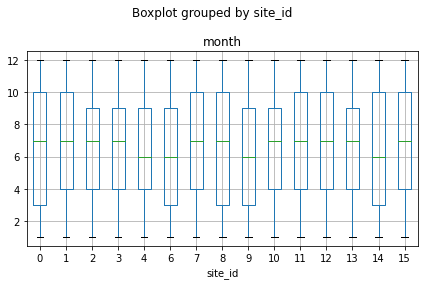

In [ ]:
plot = weather_train_df.boxplot(col, by="site_id")
plt.tight_layout() 
plt.show()

<AxesSubplot:>

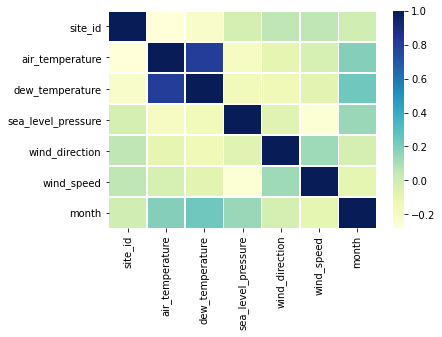

In [ ]:
sb.heatmap(weather_train_df.corr(),linewidths=.5,cmap="YlGnBu")

In [ ]:
##For every site there are multiple records taken in different timestamps
print(len(weather_train_df[weather_train_df['site_id'] == 0]))
print(len(weather_train_df[weather_train_df['site_id'] == 1]))
print(len(weather_train_df[weather_train_df['site_id'] == 2]))

7406
8651
6766


In [ ]:
weather_train_df_t = weather_train_df.groupby(['site_id', 'month']).mean()
weather_train_df_t.reset_index()

,site_id,month,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,1,14.830351,9.098083,1017.830990,220.718850,4.124441
1,0,2,16.330844,8.838636,1019.960877,215.649351,4.473864
2,0,3,21.662691,14.527217,1018.487309,192.140673,4.035933
3,0,4,22.495702,14.559008,1017.275537,160.413223,4.168264
4,0,5,24.919063,17.213732,1016.040065,180.630048,3.736995
...,...,...,...,...,...,...,...
175,15,8,22.616636,17.500555,1017.525878,188.983364,3.366359
176,15,9,17.208503,12.344362,1019.955268,169.279113,3.242144
177,15,10,10.391219,6.956810,1019.793728,212.025090,4.143907
178,15,11,5.474095,1.120571,1017.960762,225.047619,4.486286


## Merge files

In [ ]:
merged_df = sample_train_df.merge(building_metadata_df, on='building_id')
merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet
0,0,electricity,1,0.148491,0.013622,0,Education,7432
1,0,electricity,2,0.000000,0.000000,0,Education,7432
2,0,electricity,3,0.000000,0.000000,0,Education,7432
3,0,electricity,4,0.108561,0.007497,0,Education,7432
4,0,electricity,5,80.676614,2.008154,0,Education,7432
...,...,...,...,...,...,...,...,...
28327,1448,electricity,8,3.328552,1.452034,15,Office,92271
28328,1448,electricity,9,3.216560,1.425956,15,Office,92271
28329,1448,electricity,10,3.307445,1.448195,15,Office,92271
28330,1448,electricity,11,3.430587,1.477658,15,Office,92271


In [ ]:
merged_df = merged_df.merge(weather_train_df_t, on=['site_id', 'month'])
merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,electricity,1,0.148491,0.013622,0,Education,7432,14.830351,9.098083,1017.830990,220.718850,4.124441
1,1,electricity,1,0.502991,0.075676,0,Education,2720,14.830351,9.098083,1017.830990,220.718850,4.124441
2,2,electricity,1,0.002258,0.001473,0,Education,5376,14.830351,9.098083,1017.830990,220.718850,4.124441
3,3,electricity,1,0.000000,0.000000,0,Education,23685,14.830351,9.098083,1017.830990,220.718850,4.124441
4,4,electricity,1,0.148025,0.007687,0,Education,116607,14.830351,9.098083,1017.830990,220.718850,4.124441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27259,1444,electricity,8,5.568761,1.846364,15,Entertainment/public assembly,19619,22.616636,17.500555,1017.525878,188.983364,3.366359
27260,1445,electricity,8,4.237983,1.609875,15,Education,4298,22.616636,17.500555,1017.525878,188.983364,3.366359
27261,1446,electricity,8,3.391467,0.949666,15,Entertainment/public assembly,11265,22.616636,17.500555,1017.525878,188.983364,3.366359
27262,1447,electricity,8,180.494730,5.193564,15,Lodging/residential,29775,22.616636,17.500555,1017.525878,188.983364,3.366359


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27264 entries, 0 to 27263
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         27264 non-null  int64  
 1   meter               27264 non-null  object 
 2   month               27264 non-null  int64  
 3   meter_reading       27264 non-null  float64
 4   meter_reading_log   27264 non-null  float64
 5   site_id             27264 non-null  int64  
 6   primary_use         27264 non-null  object 
 7   square_feet         27264 non-null  int64  
 8   air_temperature     27264 non-null  float64
 9   dew_temperature     27264 non-null  float64
 10  sea_level_pressure  27264 non-null  float64
 11  wind_direction      27264 non-null  float64
 12  wind_speed          27264 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.9+ MB


In [ ]:
merged_df.shape

(27264, 13)

In [ ]:
merged_df.isnull().sum()

building_id           0
meter                 0
month                 0
meter_reading         0
meter_reading_log     0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [ ]:
merged_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

<AxesSubplot:>

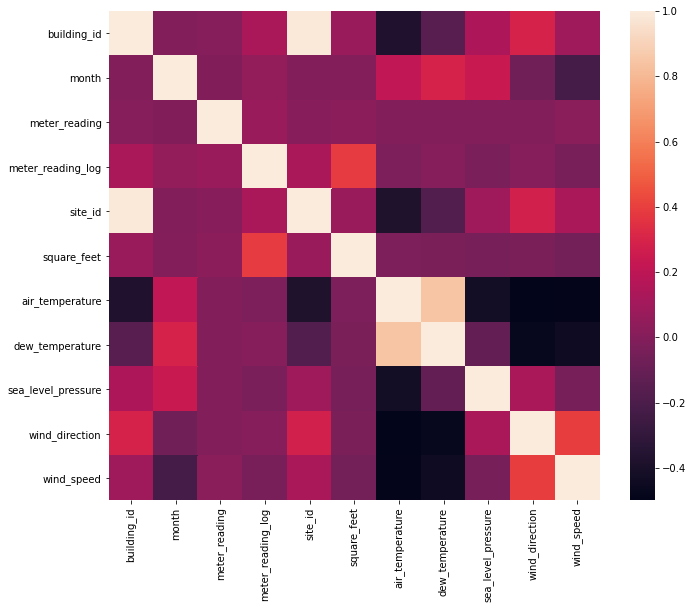

In [ ]:
#Check correlation betweeen features
corr = merged_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(corr)

In [ ]:
merged_df['primary_use'].value_counts()

Education                        10831
Office                            6004
Lodging/residential               3035
Entertainment/public assembly     2970
Public services                   2265
Healthcare                         540
Other                              332
Parking                            293
Food sales and service             156
Warehouse/storage                  155
Retail                             155
Manufacturing/industrial           144
Services                           132
Technology/science                 120
Utility                             84
Religious worship                   48
Name: primary_use, dtype: int64

In [ ]:
#Mean Of meter_reading by primary_use
merged_df.groupby('primary_use').meter_reading.agg(['mean'])

,mean
primary_use,
Education,4816.912493
Entertainment/public assembly,502.983846
Food sales and service,304.391502
Healthcare,746.526579
Lodging/residential,280.255432
Manufacturing/industrial,345.062557
Office,530.152950
Other,154.128865
Parking,168.876376


In [ ]:
#encode columns to be able to build models for it
encoder = LabelEncoder()
merged_df['primary_use'] = encoder.fit_transform(merged_df['primary_use'])
merged_df['meter'].replace({"electricity":0, "chilledwater":1, "steam":2, "hotwater":3},inplace=True)

merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,0,1,0.148491,0.013622,0,0,7432,14.830351,9.098083,1017.830990,220.718850,4.124441
1,1,0,1,0.502991,0.075676,0,0,2720,14.830351,9.098083,1017.830990,220.718850,4.124441
2,2,0,1,0.002258,0.001473,0,0,5376,14.830351,9.098083,1017.830990,220.718850,4.124441
3,3,0,1,0.000000,0.000000,0,0,23685,14.830351,9.098083,1017.830990,220.718850,4.124441
4,4,0,1,0.148025,0.007687,0,0,116607,14.830351,9.098083,1017.830990,220.718850,4.124441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27259,1444,0,8,5.568761,1.846364,15,1,19619,22.616636,17.500555,1017.525878,188.983364,3.366359
27260,1445,0,8,4.237983,1.609875,15,0,4298,22.616636,17.500555,1017.525878,188.983364,3.366359
27261,1446,0,8,3.391467,0.949666,15,1,11265,22.616636,17.500555,1017.525878,188.983364,3.366359
27262,1447,0,8,180.494730,5.193564,15,4,29775,22.616636,17.500555,1017.525878,188.983364,3.366359


In [ ]:
merged_df.to_csv("merged_df.csv", index=False)

## Kmeans clustering

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 43.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=cf0d61875e38ea6abc5ef9e1391cdf44c5a67f5a8a31af91a7ec54931fc8dc4c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
from pyspark import SparkContext

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

In [5]:
df = spark.read.csv('merged_df.csv', header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- building_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- meter_reading: double (nullable = true)
 |-- meter_reading_log: double (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- primary_use: integer (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)



In [7]:
df.columns

['building_id',
 'meter',
 'month',
 'meter_reading',
 'meter_reading_log',
 'site_id',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [8]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ['meter',
 'meter_reading',
 'meter_reading_log',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']
feature_vector=VectorAssembler(inputCols=feature_cols, outputCol='features')

data = feature_vector.transform(df)
final_data = feature_vector.transform(df).select('site_id', 'features')
final_data.show()

+-------+--------------------+
|site_id|            features|
+-------+--------------------+
|      0|[0.0,0.1484912248...|
|      0|[0.0,0.5029905017...|
|      0|[0.0,0.0022584558...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1480251290...|
|      0|[0.0,0.0074192028...|
|      0|[0.0,0.0,0.0,4.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,0.0,0.0,1.0,...|
|      0|[0.0,1.6593674911...|
|      0|[0.0,0.9098783303...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1844756756...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,7.2232663043...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|
+-------+--------------------+
only showing top 20 rows



In [9]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features',outputCol='zfeatures', withStd=True, withMean=False)

scalerModel = scaler.fit(final_data)
cluster_input_data=scalerModel.transform(final_data)
cluster_input_data.show()

+-------+--------------------+--------------------+
|site_id|            features|           zfeatures|
+-------+--------------------+--------------------+
|      0|[0.0,0.1484912248...|[0.0,1.1366363316...|
|      0|[0.0,0.5029905017...|[0.0,3.8501755194...|
|      0|[0.0,0.0022584558...|[0.0,1.7287506461...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1480251290...|[0.0,1.1330685693...|
|      0|[0.0,0.0074192028...|[0.0,5.6790800765...|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|
|      0|[0.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.28...|
|      0|[0.0,1.6593674911...|[0.0,1.2701743014...|
|      0|[0.0,0.9098783303...|[0.0,6.9647264924...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1844756756...|[0.0,1.4120817945...|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|
|      0|[0.

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [10]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='zfeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,26):
    KMeans_algo=KMeans(featuresCol='zfeatures', k=i)   
    KMeans_fit=KMeans_algo.fit(cluster_input_data)
    output=KMeans_fit.transform(cluster_input_data)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print("At k = ", i , " Silhouette Score: ",score)
    
print("done")

At k =  2  Silhouette Score:  0.3217998344915905
At k =  3  Silhouette Score:  0.24863721725405394
At k =  4  Silhouette Score:  0.14230291129616907
At k =  5  Silhouette Score:  0.1709519440594425
At k =  6  Silhouette Score:  0.20310379765310355
At k =  7  Silhouette Score:  0.19716730358419113
At k =  8  Silhouette Score:  0.20319118980168652
At k =  9  Silhouette Score:  0.202742009800043
At k =  10  Silhouette Score:  0.2376494014945021
At k =  11  Silhouette Score:  0.24578372560206238
At k =  12  Silhouette Score:  0.24982672203131476
At k =  13  Silhouette Score:  0.2444498269183011
At k =  14  Silhouette Score:  0.2428431037758012
At k =  15  Silhouette Score:  0.24195157363973718
At k =  16  Silhouette Score:  0.2338244699283147
At k =  17  Silhouette Score:  0.24793996201434568
At k =  18  Silhouette Score:  0.20565827588700308
At k =  19  Silhouette Score:  0.2585083220484422
At k =  20  Silhouette Score:  0.24740178999019255
At k =  21  Silhouette Score:  0.251231149305005

Text(0, 0.5, 'cost')

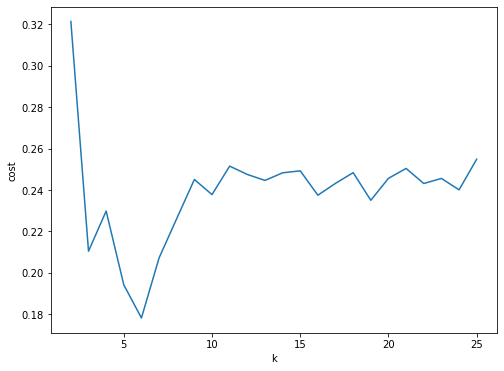

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,26),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Th optimal number of clusters is 11

In [11]:
k=11
kmeans= KMeans(featuresCol='zfeatures', k=k)
model = kmeans.fit(cluster_input_data)

In [12]:
clust_output = model.transform(cluster_input_data)
clust_output.show(10)

+-------+--------------------+--------------------+----------+
|site_id|            features|           zfeatures|prediction|
+-------+--------------------+--------------------+----------+
|      0|[0.0,0.1484912248...|[0.0,1.1366363316...|         5|
|      0|[0.0,0.5029905017...|[0.0,3.8501755194...|         5|
|      0|[0.0,0.0022584558...|[0.0,1.7287506461...|         5|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.1480251290...|[0.0,1.1330685693...|         5|
|      0|[0.0,0.0074192028...|[0.0,5.6790800765...|         5|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|         3|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|         3|
+-------+--------------------+--------------------+----------+
only showing top 10 rows



In [13]:
clust_output.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3078|
|         6|    4|
|         3| 3568|
|         5| 3723|
|         9|  954|
|         4| 2082|
|         8| 1992|
|         7| 2319|
|        10| 2901|
|         2| 3601|
|         0| 3042|
+----------+-----+



In [14]:
rows = clust_output.collect()
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-------+--------------------+--------------------+----------+
|site_id|            features|           zfeatures|prediction|
+-------+--------------------+--------------------+----------+
|      0|[0.0,0.1484912248...|[0.0,1.1366363316...|         5|
|      0|[0.0,0.5029905017...|[0.0,3.8501755194...|         5|
|      0|[0.0,0.0022584558...|[0.0,1.7287506461...|         5|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.1480251290...|[0.0,1.1330685693...|         5|
|      0|[0.0,0.0074192028...|[0.0,5.6790800765...|         5|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|         3|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         5|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|         3|
|      0|[0.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.28...|         5|
|      0|[0.0,1.6593674911...|[0.0,1.2701743014...|         5|
|      0|[0.0,0.9098783303...|[0.0,6.9647264924...|    

In [15]:
df_pred.printSchema()

root
 |-- site_id: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- zfeatures: vector (nullable = true)
 |-- prediction: long (nullable = true)



In [16]:
X = df_pred.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(feature_cols)

In [17]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

df_pred = df_pred.drop("features", "zfeatures")
df_pred = df_pred.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
X = X.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

final_pred_df = X.join(df_pred, on=["row_index"]).drop("row_index")
final_pred_df.show()

+-----+--------------------+--------------------+-----------+-----------+------------------+-----------------+------------------+-----------------+------------------+-------+----------+
|meter|       meter_reading|   meter_reading_log|primary_use|square_feet|   air_temperature|  dew_temperature|sea_level_pressure|   wind_direction|        wind_speed|site_id|prediction|
+-----+--------------------+--------------------+-----------+-----------+------------------+-----------------+------------------+-----------------+------------------+-------+----------+
|  0.0|  0.1484912248628885| 0.01362217674258455|        0.0|     7432.0|14.830351437699683|9.098083067092665|1017.8309904153361|220.7188498402556|4.1244408945686555|      0|         5|
|  0.0|  0.5029905017921147| 0.07567642121546515|        0.0|     2720.0|14.830351437699683|9.098083067092665|1017.8309904153361|220.7188498402556|4.1244408945686555|      0|         5|
|  0.0|0.002258455882352941|0.001473113208880...|        0.0|     5376

## SparkML preprocessing

In [18]:
final_pred_df = final_pred_df.drop("meter_reading")

In [19]:
feature_cols = ['meter',
 'site_id',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

feature_vector=VectorAssembler(inputCols=feature_cols, outputCol='features')

models_data = feature_vector.transform(final_pred_df).select('meter_reading_log', 'features', 'prediction')
models_data.show()

+--------------------+--------------------+----------+
|   meter_reading_log|            features|prediction|
+--------------------+--------------------+----------+
| 0.01362217674258455|[0.0,0.0,0.0,7432...|         5|
| 0.07567642121546515|[0.0,0.0,0.0,2720...|         5|
|0.001473113208880...|[0.0,0.0,0.0,5376...|         5|
|                 0.0|[0.0,0.0,0.0,2368...|         5|
|0.007686640281007755|[0.0,0.0,0.0,1166...|         5|
|0.004430891378755459|[0.0,0.0,0.0,8000...|         5|
|                 0.0|[0.0,0.0,4.0,2792...|         3|
|                 0.0|[0.0,0.0,0.0,1210...|         5|
|                 0.0|[0.0,0.0,0.0,6080...|         5|
|                 0.0|[0.0,0.0,6.0,2700...|         3|
|                 0.0|[0.0,0.0,1.0,3707...|         5|
| 0.06747590715320322|[0.0,0.0,0.0,4907...|         5|
|0.053470037352233005|[0.0,0.0,4.0,3710...|         3|
|                 0.0|[0.0,0.0,0.0,9938...|         5|
|0.008357567948149352|[0.0,0.0,0.0,8625...|         5|
|         

In [20]:
models_data_clusers = models_data.filter((models_data.prediction == 2) | (models_data.prediction == 5) | (models_data.prediction == 3) | (models_data.prediction == 1) | (models_data.prediction == 10) )
models_data_clusers.show()

+--------------------+--------------------+----------+
|   meter_reading_log|            features|prediction|
+--------------------+--------------------+----------+
| 0.01362217674258455|[0.0,0.0,0.0,7432...|         5|
| 0.07567642121546515|[0.0,0.0,0.0,2720...|         5|
|0.001473113208880...|[0.0,0.0,0.0,5376...|         5|
|                 0.0|[0.0,0.0,0.0,2368...|         5|
|0.007686640281007755|[0.0,0.0,0.0,1166...|         5|
|0.004430891378755459|[0.0,0.0,0.0,8000...|         5|
|                 0.0|[0.0,0.0,4.0,2792...|         3|
|                 0.0|[0.0,0.0,0.0,1210...|         5|
|                 0.0|[0.0,0.0,0.0,6080...|         5|
|                 0.0|[0.0,0.0,6.0,2700...|         3|
|                 0.0|[0.0,0.0,1.0,3707...|         5|
| 0.06747590715320322|[0.0,0.0,0.0,4907...|         5|
|0.053470037352233005|[0.0,0.0,4.0,3710...|         3|
|                 0.0|[0.0,0.0,0.0,9938...|         5|
|0.008357567948149352|[0.0,0.0,0.0,8625...|         5|
|         

In [21]:
models_data_clusers.count()

16871

In [23]:
train, test = models_data_clusers.drop('prediction').randomSplit(weights=[0.8,0.2], seed=200)

## Gradient-boosted tree regression

In [24]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'meter_reading_log', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'meter_reading_log', 'features').show(5)

+-------------------+-----------------+--------------------+
|         prediction|meter_reading_log|            features|
+-------------------+-----------------+--------------------+
|0.14065206376119585|              0.0|[0.0,0.0,0.0,7432...|
|0.20668087204561053|              0.0|[0.0,0.0,0.0,6190...|
| 0.3262853526572117|              0.0|[0.0,0.0,0.0,8625...|
|   0.57441205709734|              0.0|[0.0,0.0,0.0,9389...|
| 0.5185034438193838|              0.0|[0.0,0.0,0.0,9389...|
+-------------------+-----------------+--------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(labelCol="meter_reading_log", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.09844


## Multiple Linear Regression (MLR)

In [25]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='meter_reading_log', regParam=0.3, elasticNetParam=0.8)

lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,6.192966703844494e-06,0.0017194799391838423,0.0,0.0,0.0,0.0]
Intercept: 3.3352612861019826


In [26]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.660778
r2: 0.140599


In [33]:
trainingSummary.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|-3.3878356725355907|
|-3.3950311568882685|
|-3.3950311568882685|
|-3.3950311568882685|
| -3.403218160667519|
| -3.417155180719745|
| -3.417155180719745|
| -3.417155180719745|
| -3.417155180719745|
| -3.467937699784328|
| -3.467937699784328|
| -3.467937699784328|
| -3.467937699784328|
| -3.615765680475426|
| -3.615765680475426|
| -3.615765680475426|
| -3.615765680475426|
|-3.6201259767489082|
|-3.6201259767489082|
|-3.6201259767489082|
+-------------------+
only showing top 20 rows



In [34]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","meter_reading_log","features").filter(lr_predictions.meter_reading_log != 0).show()

+------------------+--------------------+--------------------+
|        prediction|   meter_reading_log|            features|
+------------------+--------------------+--------------------+
|3.6419194941048607| 4.76105855986088E-5|[1.0,10.0,0.0,673...|
| 4.916651114155943|7.052093961370494E-5|[1.0,7.0,0.0,3875...|
| 4.916651114155943|2.745692259057134E-4|[1.0,7.0,0.0,3875...|
| 4.017733230816003|3.986080501608002E-4|[0.0,0.0,11.0,161...|
|3.3950311568882685|0.001473113208880...|[0.0,0.0,0.0,5376...|
|3.4244701252442993| 0.00630157389709752|[0.0,0.0,6.0,1276...|
|3.3775421877255893|0.006469760616967404|[0.0,8.0,1.0,984....|
| 3.539343026520476|0.006590566603955...|[0.0,0.0,4.0,4161...|
| 3.539343026520476|0.007093219819557167|[0.0,0.0,4.0,4161...|
| 3.854793538382563|0.007129675681623275|[1.0,6.0,0.0,1208...|
| 3.403218160667519|0.007496714150041255|[0.0,0.0,0.0,7432...|
|4.1387742589667225|0.007948969332885887|[1.0,13.0,0.0,192...|
|3.7977990903804164|0.009733451329222797|[0.0,0.0,0.0,1

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="meter_reading_log",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.166125


## Decision tree regression

In [35]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'meter_reading_log')
dt_model = dt.fit(train)

In [37]:
dt_predictions = dt_model.transform(test)
dt_predictions.select("prediction","meter_reading_log","features").filter(lr_predictions.meter_reading_log != 0).show()

+------------------+--------------------+--------------------+
|        prediction|   meter_reading_log|            features|
+------------------+--------------------+--------------------+
| 1.013906154508155| 4.76105855986088E-5|[1.0,10.0,0.0,673...|
| 1.013906154508155|7.052093961370494E-5|[1.0,7.0,0.0,3875...|
| 1.013906154508155|2.745692259057134E-4|[1.0,7.0,0.0,3875...|
|0.7487595155742853|3.986080501608002E-4|[0.0,0.0,11.0,161...|
| 1.329519339352537|0.001473113208880...|[0.0,0.0,0.0,5376...|
|2.9037896837106474| 0.00630157389709752|[0.0,0.0,6.0,1276...|
|0.8474881618102132|0.006469760616967404|[0.0,8.0,1.0,984....|
|1.7512225264264725|0.006590566603955...|[0.0,0.0,4.0,4161...|
|1.7512225264264725|0.007093219819557167|[0.0,0.0,4.0,4161...|
| 4.190632551510765|0.007129675681623275|[1.0,6.0,0.0,1208...|
| 2.506487794974886|0.007496714150041255|[0.0,0.0,0.0,7432...|
| 1.013906154508155|0.007948969332885887|[1.0,13.0,0.0,192...|
|0.7487595155742853|0.009733451329222797|[0.0,0.0,0.0,1

In [38]:
dt_evaluator = RegressionEvaluator(
    labelCol="meter_reading_log", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.20964


In [39]:
dt_model.featureImportances

SparseVector(9, {0: 0.1155, 1: 0.1477, 2: 0.0232, 3: 0.4535, 4: 0.1575, 5: 0.0336, 8: 0.069})

In [40]:
train.take(1)

[Row(meter_reading_log=0.0, features=DenseVector([0.0, 0.0, 0.0, 3569.0, 22.4957, 14.559, 1017.2755, 160.4132, 4.1683]))]

In [41]:
test.take(1)

[Row(meter_reading_log=0.0, features=DenseVector([0.0, 0.0, 0.0, 7432.0, 16.3308, 8.8386, 1019.9609, 215.6494, 4.4739]))]

## Results

| ML Method           | Root Mean Squared Error (RMSE) |
| ---                 | ---                |
|    Gradient-boosted tree regression                 |      1.09844              |
| Multiple Linear regression                |      1.660778              | 
|          Decision tree regression           |          1.20964          |

The best model out of the three is the Gradient Boosted Tree model. On the other hand, the worst model is the Multiple Linear Regression model.